# Análise de correlação entre os votos em partidos (PL e PT) e atributos socioeconômicos.

In [58]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
# Dados
dep_fed_results = pd.read_csv('data/dep_fed_results.csv')
distribuicao_populacao = pd.read_csv('data/distribuicao_populacao.csv')
pib_municipios = pd.read_csv('data/pib_municipios.csv')
municipios = gpd.read_file('data/SC_Municipios_2023/SC_Municipios_2023.shp')

In [60]:
# Padronizar nomes dos municípios
dep_fed_results['nm_municipio'] = dep_fed_results['nm_municipio'].str.upper()
distribuicao_populacao['nm_mun'] = distribuicao_populacao['nm_mun'].str.upper()
pib_municipios['nm_mun'] = pib_municipios['nm_mun'].str.upper()
municipios['NM_MUN'] = municipios['NM_MUN'].str.upper()

In [61]:
# Filtrar dados relevantes
pib_municipios = pib_municipios[pib_municipios['sg_uf'] == 'SC']
pib_municipios = pib_municipios[pib_municipios['ano'] == 2020]

distribuicao_populacao = distribuicao_populacao[distribuicao_populacao['cd_municipio'].astype(str).str.startswith('42')]

In [62]:
# Partidos analisados: PT e PL
partidos_interesse = ['PL', 'PT']
dep_fed_results_pl_pt = dep_fed_results[dep_fed_results['sg_partido'].isin(partidos_interesse)]

In [63]:
# Votos por município para cada partido
votos_por_municipio_partido = dep_fed_results_pl_pt.groupby(['nm_municipio', 'sg_partido'])['qt_votos_nominais'].sum().reset_index()

In [64]:
# Merge das informações das diferentes fontes
dados_completos = votos_por_municipio_partido.merge(distribuicao_populacao, left_on='nm_municipio', right_on='nm_mun', how='left')
dados_completos = dados_completos.merge(pib_municipios[['nm_mun', 'pib', 'pip_per_capita']], on='nm_mun', how='left')

In [65]:
# Obter % dos votos para cada instância
dados_completos['perc_votos'] = dados_completos['qt_votos_nominais'] / dados_completos['tot_pop']

In [66]:
# Separação entre PL e PT
dados_pt = dados_completos[dados_completos['sg_partido'] == 'PT']
dados_pl = dados_completos[dados_completos['sg_partido'] == 'PL']

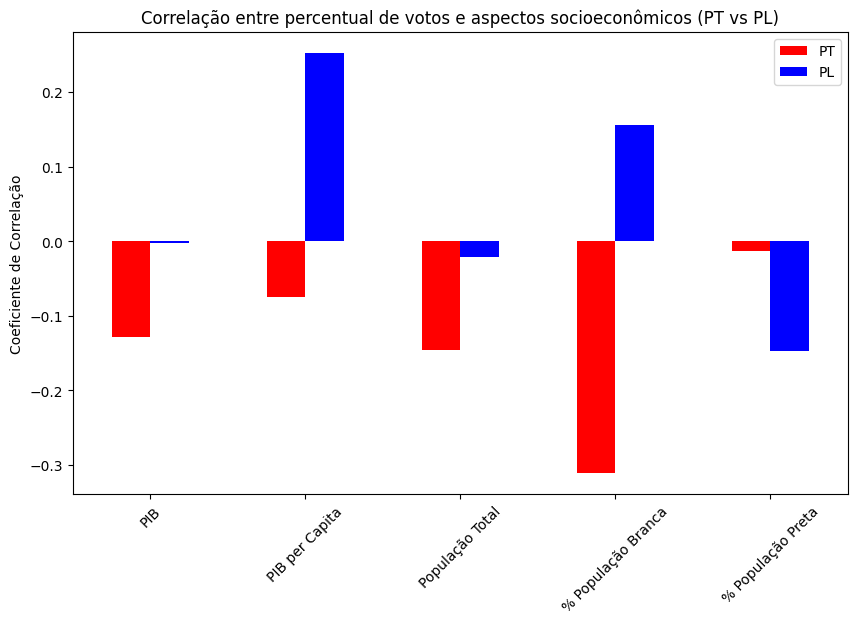

In [67]:
# Variáveis socioeconômicas para análise
variaveis_socioeconomicas = ['pib', 'pip_per_capita', 'tot_pop', 'perc_branca', 'perc_preta']

# Calculando a correlação
correlacoes_pt = dados_pt[variaveis_socioeconomicas].apply(lambda x: x.corr(dados_pt['perc_votos']))
correlacoes_pl = dados_pl[variaveis_socioeconomicas].apply(lambda x: x.corr(dados_pl['perc_votos']))

# Renomear as variáveis
mapa_nomes = {
    'pib': 'PIB',
    'pip_per_capita': 'PIB per Capita',
    'tot_pop': 'População Total',
    'perc_branca': '% População Branca',
    'perc_preta': '% População Preta'
}
correlacoes_pt.rename(index=mapa_nomes, inplace=True)
correlacoes_pl.rename(index=mapa_nomes, inplace=True)

comparacao_correlacoes = pd.DataFrame({
    'PT': correlacoes_pt,
    'PL': correlacoes_pl
})

# Plotando a comparação das correlações entre os partidos com as novas variáveis legíveis
comparacao_correlacoes.plot(kind='bar', figsize=(10, 6), color=['red', 'blue'])
plt.title('Correlação entre percentual de votos e aspectos socioeconômicos (PT vs PL)')
plt.ylabel('Coeficiente de Correlação')
plt.xticks(rotation=45)
plt.show()


In [89]:
# Calcular a diferença de porcentagem de votos (PL - PT) para cada município
dados_diferenca = dados_completos.pivot_table(
    index='nm_municipio',
    columns='sg_partido',
    values='perc_votos',
    aggfunc='sum'
).reset_index()

dados_diferenca['diferenca_perc'] = dados_diferenca['PL'] - dados_diferenca['PT']

# Mapa das diferenças de votos entre os 2 partidos
mapa_diff_votos = municipios.merge(
    dados_diferenca,
    left_on='NM_MUN',
    right_on='nm_municipio',
    how='left'
)

# Mapa dos dados do PIB
mapa_pib = municipios.merge(pib_municipios, left_on="NM_MUN", right_on="nm_mun", how="left")

# Mapa dos dados de população
mapa_pop = municipios.merge(distribuicao_populacao, left_on='NM_MUN', right_on='nm_mun', how='left')


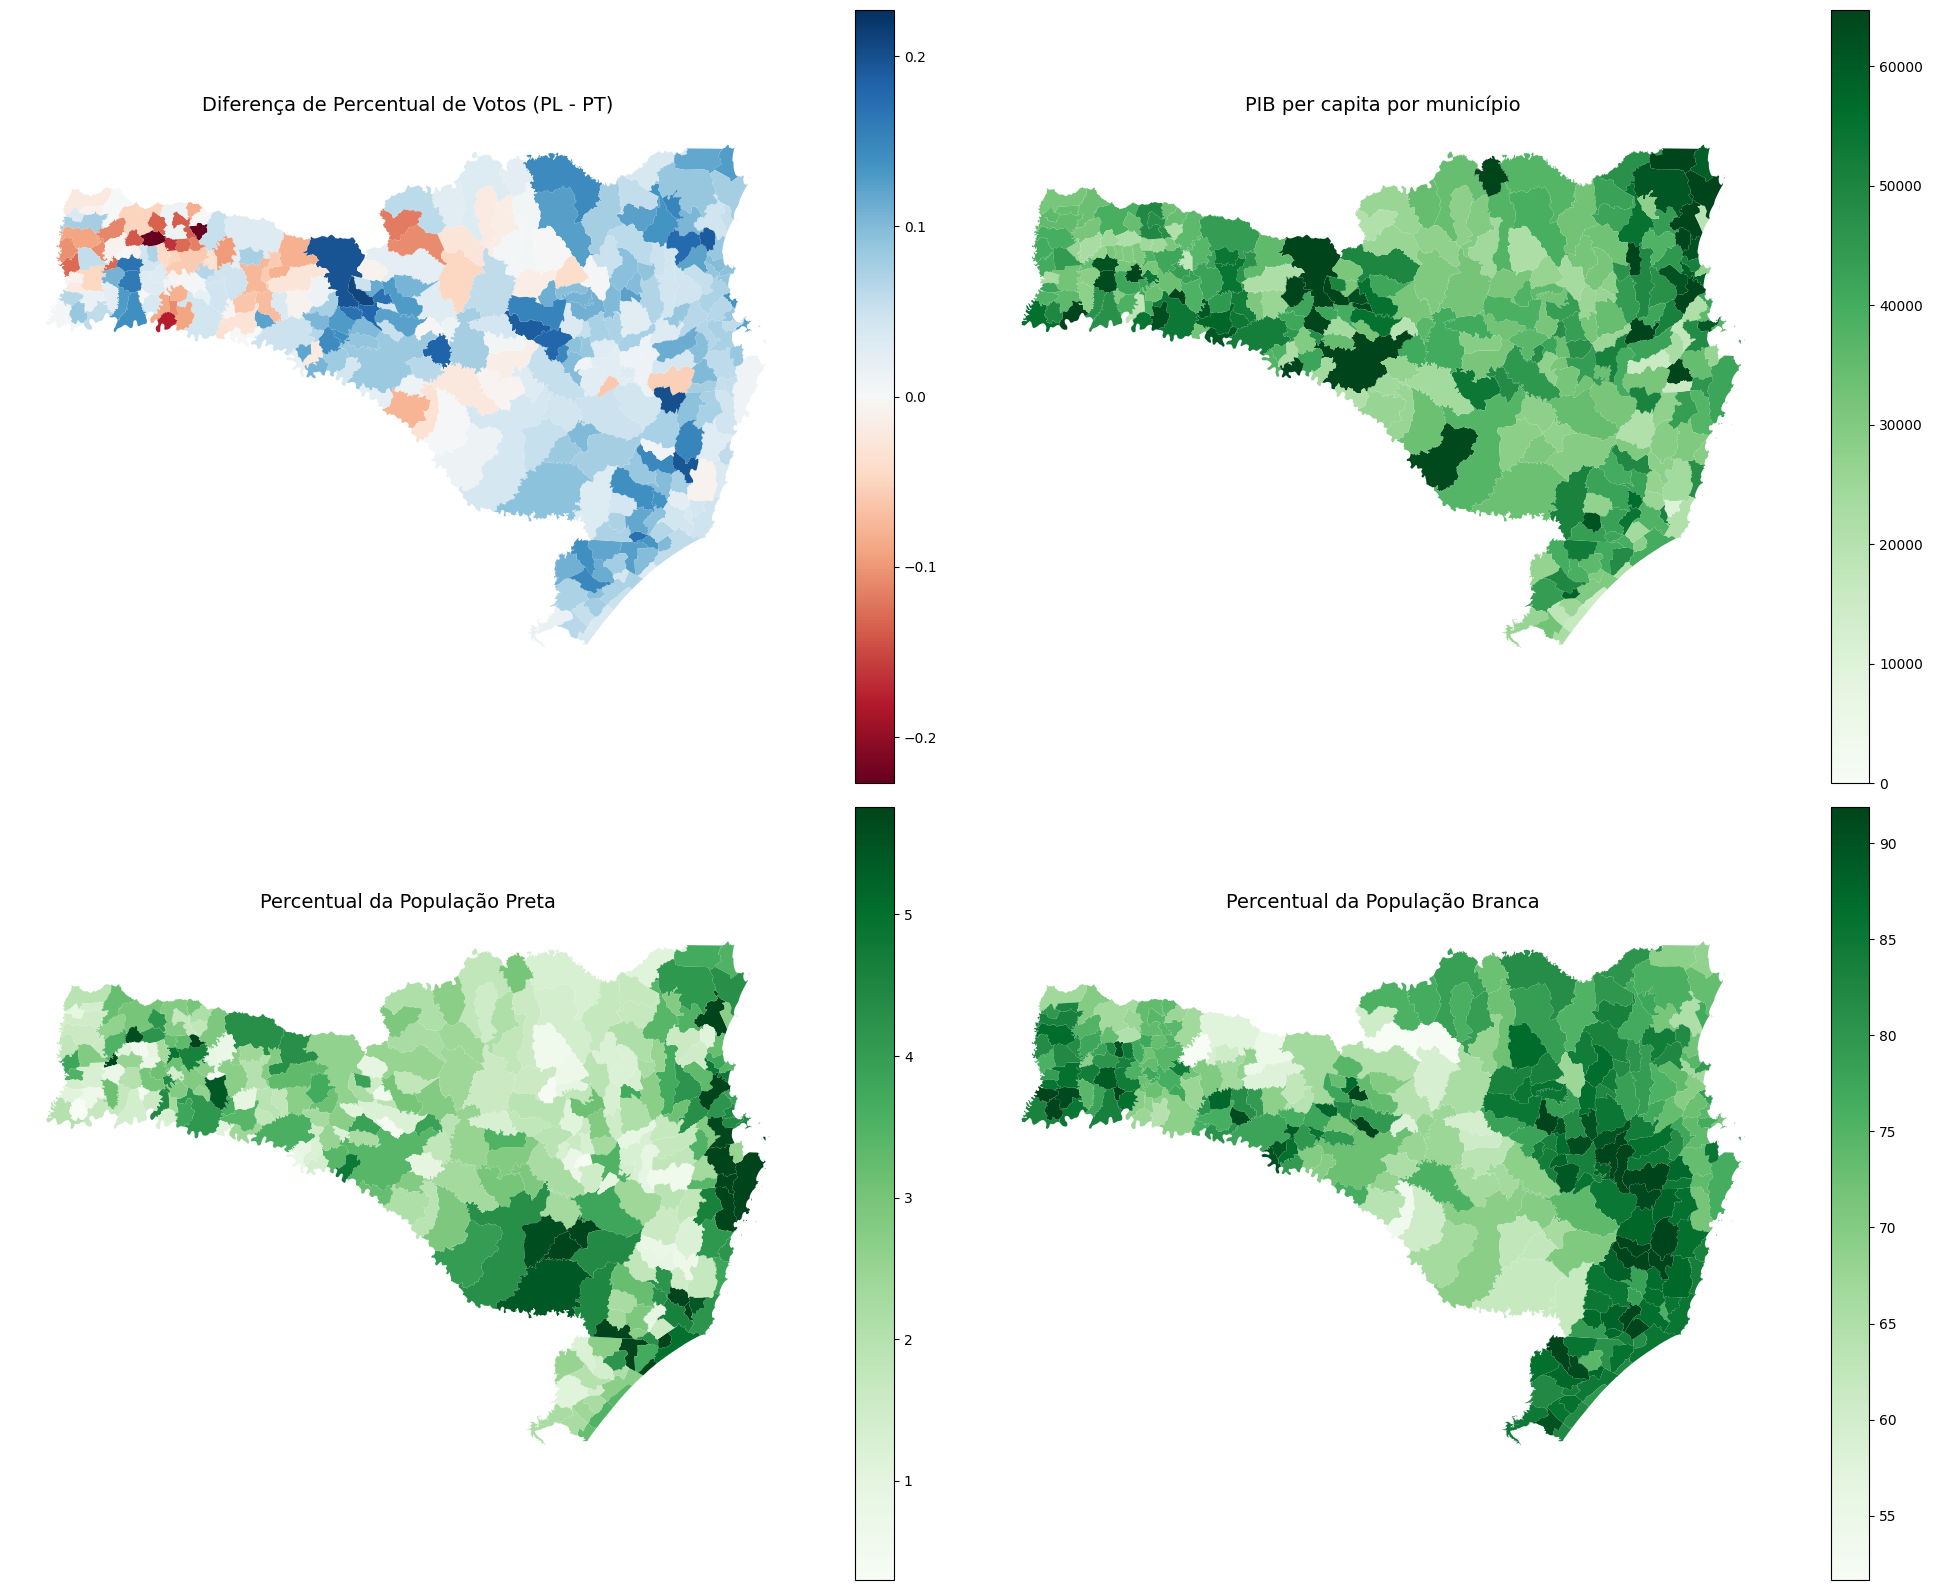

In [90]:
# Criar a figura com subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# MAPA 1: Diferença de percentual de votos (PL - PT)
mapa_diff_votos.plot(
    column='diferenca_perc',
    cmap='RdBu',
    legend=True,
    vmin=-mapa_diff_votos['diferenca_perc'].abs().max(),
    vmax=mapa_diff_votos['diferenca_perc'].abs().max(),
    ax=axes[0, 0]
)
axes[0, 0].set_title('Diferença de Percentual de Votos (PL - PT)', fontsize=14)
axes[0, 0].set_axis_off()

# MAPA 2: PIB per capita por município
mapa_pib.plot(
    column="pip_per_capita",
    cmap="Greens",
    vmin=0,
    vmax=mapa_pib['pip_per_capita'].quantile(0.95),
    legend=True,
    ax=axes[0, 1]
)
axes[0, 1].set_title("PIB per capita por município", fontsize=14)
axes[0, 1].set_axis_off()

# MAPA 3: Percentual da população preta
mapa_pop.plot(
    column="perc_preta",
    cmap="Greens",
    vmin=mapa_pop['perc_preta'].min(),
    vmax=mapa_pop['perc_preta'].quantile(0.95),
    legend=True,
    ax=axes[1, 0]
)
axes[1, 0].set_title("Percentual da População Preta", fontsize=14)
axes[1, 0].set_axis_off()

# MAPA 4: Percentual da população branca
mapa_pop.plot(
    column="perc_branca",
    cmap="Greens",
    vmin=mapa_pop['perc_branca'].quantile(0.01),
    vmax=mapa_pop['perc_branca'].quantile(0.95),
    legend=True,
    ax=axes[1, 1]
)
axes[1, 1].set_title("Percentual da População Branca", fontsize=14)
axes[1, 1].set_axis_off()


plt.tight_layout()
plt.show()
